# Is student X going to complete their online course?

### Description: For this project, we are going to predict whether a student will complete (be certified) in their course depending on a number of factors. 
### How to Run: Click run in jupyter notebook
### Author(s): rxu17
### Team Name (Kaggle): RXU
### Date: 08/01/21


Import important required libraries

In [31]:
# import general libraries
import os
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for feature engineering
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import is_numeric_dtype
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


# for splitting data
from sklearn.model_selection import train_test_split

# for our various model trainings
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# scoring
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

Read in our training data and test data

In [47]:
# input in filepath of input data
input_path = os.getcwd()

# validate path
assert os.path.isdir(input_path),\
    "{} is not a valid filepath".format(input_path)

# read in our data
train_and_validate_data = pd.read_csv("{}/edx_su2021_train.csv".format(input_path))
test_data = pd.read_csv("{}/edx_su2021_test.csv".format(input_path))

assert not train_and_validate_data.empty and not test_data.empty,\
    "training and/or test data is empty!"

## Splitting our data

In [49]:
# our features and descriptions of each
features = ['registered', # 0/1; registered for course
            'viewed', # 0/1; anyone who accessed the ‘Courseware’ tab
            'explored',# 0/1; anyone who accessed at least half of the chapters in the courseware
            'LoE_DI', # highest level of education completed
            'YoB', # year of birth
            'gender', # Possible values: m (male), f (female) and o (other)
            'grade', #  final grade in the course, ranges from 0 to 1
            'start_time_DI', # date of course registration
            'last_event_DI', # date of last interaction with course
            'nevents', # number of interactions with the course
            'ndays_act', # number of unique days student interacted with course
            'nplay_video', # number of play video events within the course
            'nchapters', # number of chapters (within the Courseware) with which the student interacted.
            'nforum_posts' # number of posts to the Discussion Forum
           ]

target = "certified"
# split our data into 80% training, 20% validation for now
validate_size = 0.2
train_data, validation_data = \
    train_test_split(train_and_validate_data, test_size=validate_size, random_state=6)

### Descriptive Statistics

Here we start looking into specific aspects of our dataset such as datatypes of the columns, range of values in each column, shape of our dataset, and a subset of our dataset

In [50]:
# sneak peak of our training data
print(train_data[features].head())

      registered  viewed  explored      LoE_DI     YoB gender grade  \
2030           1       1         0   Secondary  1988.0      m     0   
5247           1       1         1    Master's  1981.0      f  0.95   
3480           1       1         0  Bachelor's  1992.0      m  0.31   
7076           1       0         0  Bachelor's  1981.0      m     0   
8640           1       1         0   Secondary  1991.0      m     0   

     start_time_DI last_event_DI  nevents  ndays_act  nplay_video  nchapters  \
2030      11/30/12       4/22/13      8.0        1.0          NaN        1.0   
5247      10/24/12       1/16/13   5255.0       48.0        445.0       16.0   
3480      11/19/12       1/15/13    278.0        3.0          NaN        3.0   
7076       8/27/12           NaN      NaN        NaN          NaN        NaN   
8640      10/17/12       11/3/12    148.0        5.0         25.0        1.0   

      nforum_posts  
2030             0  
5247             0  
3480             0  
7076    

In [51]:
# data types of the columns
print(train_data[features].dtypes)

registered         int64
viewed             int64
explored           int64
LoE_DI            object
YoB              float64
gender            object
grade             object
start_time_DI     object
last_event_DI     object
nevents          float64
ndays_act        float64
nplay_video      float64
nchapters        float64
nforum_posts       int64
dtype: object


Note that grade is shown as having decimal values but is an object/string column later. We'll have to add this to the features we will engineer later. 

In [52]:
# print the unique values in each columns
print(train_data[features].apply(lambda col: col.unique()))

registered                                                     [1]
viewed                                                      [1, 0]
explored                                                    [0, 1]
LoE_DI           [Secondary, Master's, Bachelor's, Less than Se...
YoB              [1988.0, 1981.0, 1992.0, 1991.0, 1990.0, 1984....
gender                                                 [m, f, nan]
grade            [0, 0.95, 0.31, 0.6, 1, 0.92, 0.75, 0.89, 0.86...
start_time_DI    [11/30/12, 10/24/12, 11/19/12, 8/27/12, 10/17/...
last_event_DI    [4/22/13, 1/16/13, 1/15/13, nan, 11/3/12, 10/2...
nevents          [8.0, 5255.0, 278.0, nan, 148.0, 1.0, 1743.0, ...
ndays_act        [1.0, 48.0, 3.0, nan, 5.0, 22.0, 51.0, 34.0, 2...
nplay_video      [nan, 445.0, 25.0, 129.0, 2.0, 270.0, 1828.0, ...
nchapters        [1.0, 16.0, 3.0, nan, 9.0, 12.0, 2.0, 28.0, 6....
nforum_posts                              [0, 1, 5, 3, 2, 6, 4, 7]
dtype: object


In [53]:
# shape of our dataset
print(train_data[features].shape)

(7006, 14)


In [54]:
# see proportion of nans in each columns
print(train_data[features].apply(lambda col: col.isna().sum()*100/len(train_data)))

registered        0.000000
viewed            0.000000
explored          0.000000
LoE_DI           10.862118
YoB              10.362546
gender            8.792464
grade             4.125036
start_time_DI     0.000000
last_event_DI    17.028261
nevents          18.512703
ndays_act        18.512703
nplay_video      76.862689
nchapters        29.146446
nforum_posts      0.000000
dtype: float64


nplay_video is full of nas > 70% missing here. We'll see if the data has any correlation with our target var otherwise, it sounds worthwhile to drop this variable as a predictor. 

In [55]:
# See distribution of certified values
cert = train_data[train_data['certified'] == 1]
not_cert = train_data[train_data['certified'] ==0]

print(f'Number certified: {len(cert)} ({len(cert) * 100.0 / len(train_data):.2f}%)')
print(f'Number non-certified: {len(not_cert)} ({len(not_cert) * 100.0 / len(train_data):.2f}%)')

Number certified: 3143 (44.86%)
Number non-certified: 3863 (55.14%)


We have a pretty good balance between certified and non-certified numbers here

['registered', 'viewed', 'explored', 'YoB', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts']


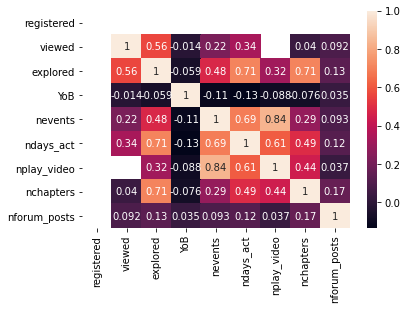

In [56]:
# only float or int columns and produce a heatmap
num_cols = train_data[features].select_dtypes(include=np.number).columns.tolist()
print(num_cols)
sns.heatmap(train_data[features][num_cols].corr(), annot=True)
plt.show()

In [57]:
cor_mat = train_data[features].corr()
cor_mat

,registered,viewed,explored,YoB,nevents,ndays_act,nplay_video,nchapters,nforum_posts
registered,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
viewed,NaN,1.000000,0.564746,-0.014121,0.216304,0.335358,NaN,0.039953,0.092296
explored,NaN,0.564746,1.000000,-0.059479,0.477613,0.710598,0.321807,0.710468,0.133175
YoB,NaN,-0.014121,-0.059479,1.000000,-0.108710,-0.134370,-0.088240,-0.076464,0.035443
nevents,NaN,0.216304,0.477613,-0.108710,1.000000,0.693119,0.837960,0.289292,0.092803
ndays_act,NaN,0.335358,0.710598,-0.134370,0.693119,1.000000,0.613114,0.490699,0.119665
nplay_video,NaN,NaN,0.321807,-0.088240,0.837960,0.613114,1.000000,0.442048,0.036803
nchapters,NaN,0.039953,0.710468,-0.076464,0.289292,0.490699,0.442048,1.000000,0.165796
nforum_posts,NaN,0.092296,0.133175,0.035443,0.092803,0.119665,0.036803,0.165796,1.000000


Here we're going to investigate into specific features of interest starting with our last_event_DI

In [58]:
train_data[features].loc[(train_data['last_event_DI'].isna()) & (train_data['certified'].eq(0))]

,registered,viewed,explored,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
7076,1,0,0,Bachelor's,1981.0,m,0,8/27/12,NaN,NaN,NaN,NaN,NaN,0
4877,1,0,0,Bachelor's,1989.0,m,0,12/24/12,NaN,NaN,NaN,NaN,NaN,0
4749,1,0,0,Secondary,1991.0,m,0,8/7/12,NaN,NaN,NaN,NaN,NaN,0
783,1,0,0,Secondary,1991.0,f,NaN,7/26/13,NaN,NaN,NaN,NaN,NaN,0
712,1,0,0,Secondary,1995.0,f,0,12/21/12,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,1,0,0,Secondary,1993.0,m,0,10/9/12,NaN,NaN,NaN,NaN,NaN,0
7452,1,0,0,NaN,NaN,NaN,0,10/1/12,NaN,NaN,NaN,NaN,NaN,0
3266,1,0,0,NaN,NaN,NaN,0,12/21/12,NaN,NaN,NaN,NaN,NaN,0
7045,1,0,0,Doctorate,1949.0,f,0,1/17/13,NaN,NaN,NaN,NaN,NaN,0


In [59]:
train_data[features].loc[(train_data['last_event_DI'].isna()) & ~(train_data['certified'].eq(0))]

,registered,viewed,explored,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts


Here we can presume that since last event DI is blank/missing, the student didn't interact with the course at all, therefore the nevents, ndays_act, nplay_video and nchapters are 0, (since viewed, and explored are 0 as well). It also stated in the description of the nevents that it's the number of interactions with the course, recorded in the tracking logs; blank if no interactions beyond registration. We will feature engineer this to be 0s for those variables related to the course interactions. 



In [60]:
train_data[features].loc[(train_data['start_time_DI'].isna())]

,registered,viewed,explored,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts


Looking at histogram of features by whether they are certified

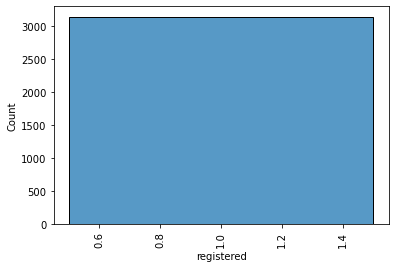

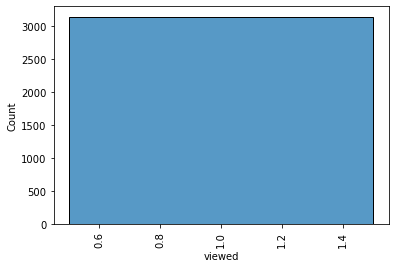

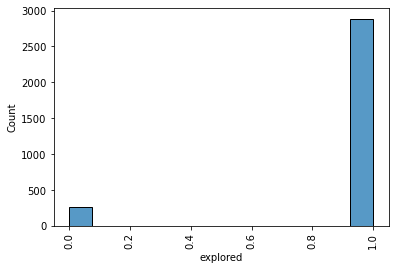

doesn't work for LoE_DI


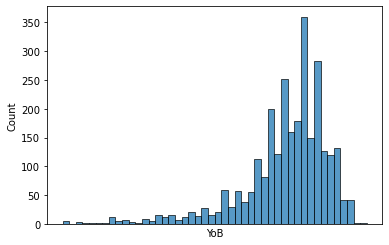

doesn't work for gender


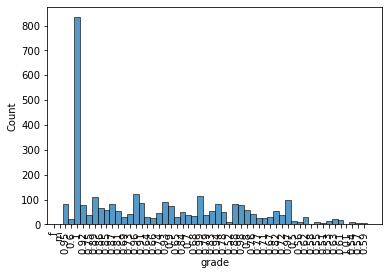

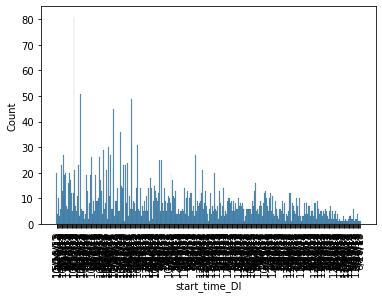

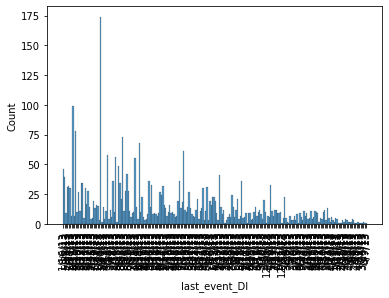

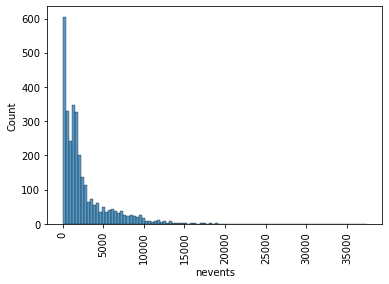

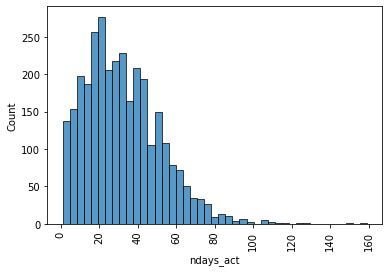

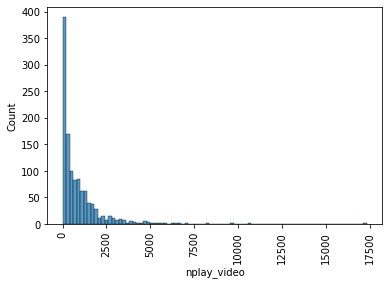

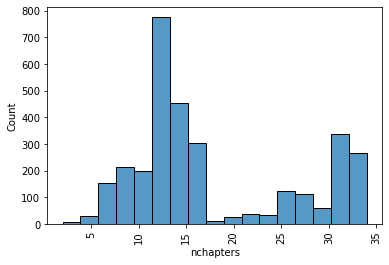

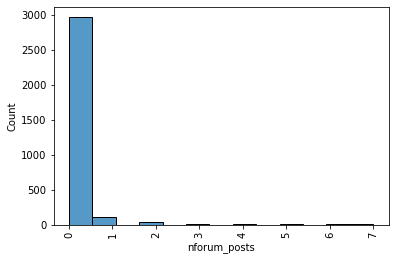

In [61]:
for feat in features:
    try:
        sns.histplot(data=train_data[features].loc[train_data.certified == 1], x=feat)
        plt.xticks(rotation=90)
        plt.show()
    except:
        print("doesn't work for {}".format(feat))


In [62]:
train_data[features].loc[train_data.certified == 1, 'viewed'].unique()

array([1])

Or not certified

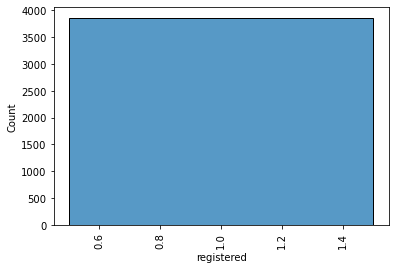

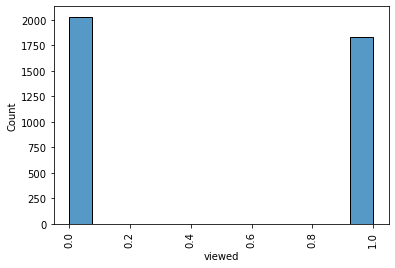

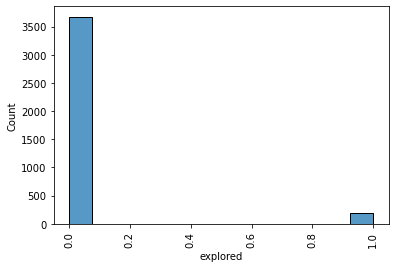

doesn't work for LoE_DI


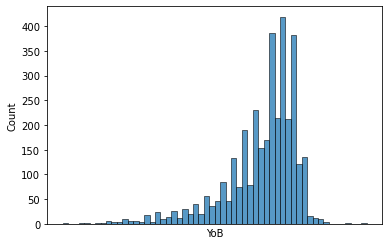

doesn't work for gender
doesn't work for grade


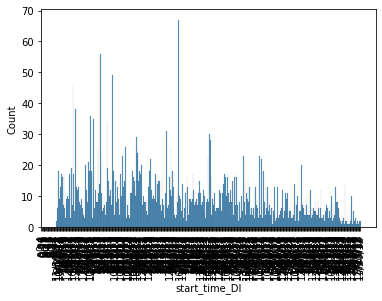

doesn't work for last_event_DI


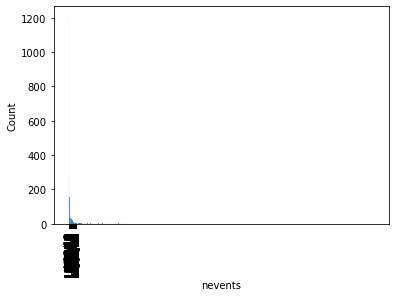

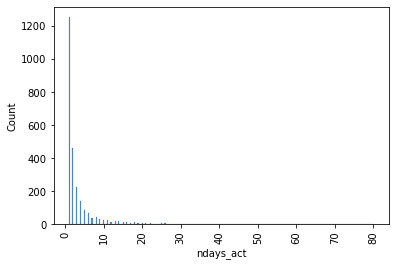

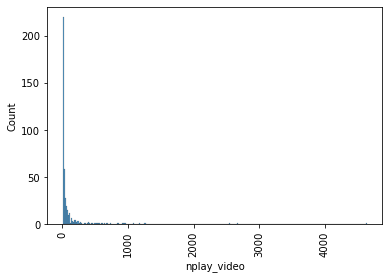

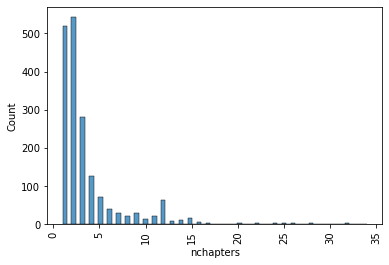

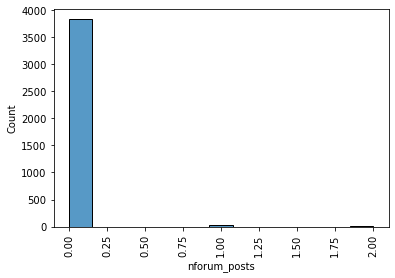

In [63]:
for feat in features:
    try:
        sns.histplot(data=train_data[features].loc[train_data.certified == 0], x=feat)
        plt.xticks(rotation=90)
        plt.show()
    except:
        print("doesn't work for {}".format(feat))

### Feature Engineering

Here we try some feature engineering techniques on our data. Some things to try is creating age variable from our year of birth data, creating an education level based on increasing education (less than secondary to doctorate), as well as dummy variables for gender and country where participant is from. 

We also try some base level imputation techniques like using the mode, mean, and/or median to fill in the NAs in the data. Special consideration was for a subset of our data where last_event_DI was blank, and it was decided to fill in "nevents", "ndays_act", "nplay_video", "nchapters" with 0s as we can presume that if they didn't access the course content (viewed, etc) they didn't have anything for any of those variables. 

Didn't get enough time to try out the KNN imputation technique but for future modeling improvement, might be improvement for the model

In [64]:
def feature_engineer(input_df : pd.DataFrame, features_to_update : list = None, nan_method : str = None,
                    feat_method : str = None, n_neighbors : int = 5) -> pd.DataFrame:
    ''' Parameters
        ================
        input_data - our input training data
        features_to_update - our list of features to process nan/feat method on
        nan_method - what to replace nan with, Allowed values: ['mode', 'mean', 'median', 'knn']
        feat_method - what to process for data, Allowed values: ['impute', 'encode']
        n_neighbors - if knn in nan_method specified, how many neighbors to use
    '''
    input_data = input_df.copy()
    if features_to_update is None:
        features_to_update = list(input_data.columns)
        
    for feat in features_to_update:
        if feat_method == "encode":
            if feat == "YoB":
                # create age variable
                input_data['age'] = (2020 - input_data[feat]) + 1
            elif feat == "LoE_DI":
                # create variable where education level is encoded
                edu_lvls = {"Master's":4, "Bachelor's" :3, 'Secondary':2, 'Doctorate':5,
                           'Less than Secondary':1}
                input_data['edu_lvl'] = input_data[feat].map(edu_lvls)
            elif feat in ['gender', 'final_cc_cname_DI']:
                feat_encoded = pd.get_dummies(input_data[feat])
                input_data = input_data.drop(feat,axis = 1)
                input_data = input_data.join(feat_encoded)
                
        elif feat_method == "impute":
            # fill in NAs
            input_data[feat] = input_data[feat].replace('nan', np.nan)
            
            # replace blanks in grade with nan values
            if feat == "grade":
                input_data.loc[input_data[feat] == " ", feat] = np.nan
                input_data[feat] = input_data[feat].astype(float)
            elif feat == "last_event_DI":
                replace_cols = ["nevents", "ndays_act", "nplay_video", "nchapters"]
                train_data.loc[(train_data['last_event_DI'].isna()), replace_cols] = 0
                
            # replace blankk/nas with set nan method
            if nan_method == "mean" and is_numeric_dtype(input_data[feat]):
                nan_method_val = input_data[feat].mean()
                input_data.loc[input_data[feat].isna(), feat] = nan_method_val.values[0]
            elif nan_method == "mode":
                nan_method_val = input_data[feat].mode()
                input_data.loc[input_data[feat].isna(), feat] = nan_method_val.values[0]
            elif nan_method == "median" and is_numeric_dtype(input_data[feat]):
                nan_method_val = input_data[feat].median()
                input_data.loc[input_data[feat].isna(), feat] = nan_method_val.values[0]
            elif nan_method == "knn" and is_numeric_dtype(input_data[feat]):
                scaler = MinMaxScaler()
                input_data = pd.DataFrame(scaler.fit_transform(input_data), columns = input_data.columns)
                imputer = KNNImputer(n_neighbors=n_neighbors)
                input_data = pd.DataFrame(imputer.fit_transform(input_data),columns = input_data.columns)
    
    return(input_data)


In [65]:
train_data = train_data[features + [target]]
# let's impute and encode our training data
train_stage1 = feature_engineer(input_df = train_data, 
                               features_to_update = ['gender', 'LoE_DI', 'YoB', 'grade', 'nevents', 
                                                     'ndays_act', 'nplay_video', 'nchapters', 'last_event_DI'],
                        nan_method = "mode", feat_method = "impute")

train_stage2 = feature_engineer(input_df = train_stage1, 
                        features_to_update = ['gender', 'LoE_DI', 'YoB', 'grade'],
                        feat_method = "encode")

# do the same for our validation data
valid_stage1 = feature_engineer(input_df = validation_data, 
                               features_to_update = ['gender', 'LoE_DI', 'YoB', 'grade', 'nevents', 
                                                     'ndays_act', 'nplay_video', 'nchapters', 'last_event_DI'],
                        nan_method = "mode", feat_method = "impute")

valid_stage2 = feature_engineer(input_df = valid_stage1, 
                        features_to_update = ['gender', 'LoE_DI', 'YoB', 'grade'],
                        feat_method = "encode")


# do the same for our test data
test_data_tran = feature_engineer(input_df =  test_data,
                                  features_to_update = ['gender', 'LoE_DI', 'YoB', 'grade', 'nevents', 
                                                     'ndays_act', 'nplay_video', 'nchapters', 'last_event_DI'],
                                  nan_method = "mode", feat_method = "impute")

test_data_tran = feature_engineer(input_df = test_data_tran,
                                  features_to_update = ['gender', 'LoE_DI', 'YoB', 'grade'],
                                  feat_method = "encode")



In [66]:
# how many NAs are in our training data
print(train_stage2.apply(lambda col: col.isna().sum()*100/len(train_stage2)))

registered       0.0
viewed           0.0
explored         0.0
LoE_DI           0.0
YoB              0.0
grade            0.0
start_time_DI    0.0
last_event_DI    0.0
nevents          0.0
ndays_act        0.0
nplay_video      0.0
nchapters        0.0
nforum_posts     0.0
certified        0.0
f                0.0
m                0.0
edu_lvl          0.0
age              0.0
dtype: float64


In [67]:
# how many NAs are left in our testing data
print(test_data_tran.apply(lambda col: col.isna().sum()*100/len(test_data_tran)))

course_id            0.0
userid_DI            0.0
registered           0.0
viewed               0.0
explored             0.0
final_cc_cname_DI    0.0
LoE_DI               0.0
YoB                  0.0
grade                0.0
start_time_DI        0.0
last_event_DI        0.0
nevents              0.0
ndays_act            0.0
nplay_video          0.0
nchapters            0.0
nforum_posts         0.0
f                    0.0
m                    0.0
edu_lvl              0.0
age                  0.0
dtype: float64


In [68]:
# update grade here in train_data to see corr before and after imputation for grade
# looking at the correlation of the updated features in our original training data

train_data.loc[train_data["grade"] == " ", "grade"] = np.nan
train_data["grade"] = train_data["grade"].astype(float)
cor_mat = train_data[['grade', 'nevents', 
                      'ndays_act', 'nplay_video', 'nchapters', 'certified','LoE_DI', 'YoB']].corr()
cor_mat

,grade,nevents,ndays_act,nplay_video,nchapters,certified,YoB
grade,1.000000,0.503464,0.741085,0.483352,0.699449,0.976876,-0.019294
nevents,0.503464,1.000000,0.711719,0.852091,0.371307,0.502443,-0.104133
ndays_act,0.741085,0.711719,1.000000,0.669505,0.592679,0.729028,-0.126029
nplay_video,0.483352,0.852091,0.669505,1.000000,0.539414,0.458148,-0.096089
nchapters,0.699449,0.371307,0.592679,0.539414,1.000000,0.756906,-0.075893
certified,0.976876,0.502443,0.729028,0.458148,0.756906,1.000000,-0.019057
YoB,-0.019294,-0.104133,-0.126029,-0.096089,-0.075893,-0.019057,1.000000


In [69]:
# looking at the correlation of the updated features in our training data
cor_mat = train_stage2[['LoE_DI', 'grade', 'nevents', 
                      'ndays_act', 'nplay_video', 'nchapters', 'certified', 'f', 'm', 'edu_lvl', 'age']].corr()
cor_mat

,grade,nevents,ndays_act,nplay_video,nchapters,certified,f,m,edu_lvl,age
grade,1.000000,0.513379,0.746225,0.281298,0.518284,0.977762,0.016508,-0.016508,0.100343,0.017345
nevents,0.513379,1.000000,0.713385,0.832869,0.284028,0.505109,0.132697,-0.132697,0.239268,0.101976
ndays_act,0.746225,0.713385,1.000000,0.463999,0.446094,0.728639,0.017794,-0.017794,0.166075,0.113770
nplay_video,0.281298,0.832869,0.463999,1.000000,0.059245,0.258762,0.088414,-0.088414,0.171522,0.064334
nchapters,0.518284,0.284028,0.446094,0.059245,1.000000,0.572220,0.022212,-0.022212,0.054735,0.055748
certified,0.977762,0.505109,0.728639,0.258762,0.572220,1.000000,0.028872,-0.028872,0.095819,0.017509
f,0.016508,0.132697,0.017794,0.088414,0.022212,0.028872,1.000000,-1.000000,0.092995,0.045318
m,-0.016508,-0.132697,-0.017794,-0.088414,-0.022212,-0.028872,-1.000000,1.000000,-0.092995,-0.045318
edu_lvl,0.100343,0.239268,0.166075,0.171522,0.054735,0.095819,0.092995,-0.092995,1.000000,0.517775
age,0.017345,0.101976,0.113770,0.064334,0.055748,0.017509,0.045318,-0.045318,0.517775,1.000000


As a result of imputation of NAs using mode method, it looks like the correlations with certified (our target variable) haven't really improved much and the correlation with nplay_video decreased. nchapters seemed to have the greatest improvement after imputation. Adding age didn't seemed to add much explantary value to the data. 

## Feature Selection

Here we use a base level feature selection method called recursive feature elimination.

It's given an external estimator that assigns weights to features, and the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. Here we use Random Forest as our external estimator to assign weights to features. 

In [70]:
# here are the best features we have decided to use
best_features = ["viewed", 
                 "explored",
                 "nevents",
                 #"nplay_video",
                 "grade",
                 #"ndays_act",
                 "nchapters",
                 "nforum_posts",
                 #"age",
                 #"f",
                 #"m",
                 #'edu_lvl'
                ]

target = 'certified'

Reasoning for the features selected: 

#### viewed: Generally we saw a correlation between someone having viewed the page
#### explored: Generally saw a trend with more exploration as the grade goes up and with certified vs non-certified people
#### nevents: Generally saw a trend with more events as the grade goes up and with certified vs non-certified people
#### nplay_video: We removed this because we believe that there were too many missing data points to keep this (> 70% of the training data missing)
#### grade: Grade of someone in the class has the strongest correlation/explanation for whether someone is certified as seen by the histograms and the correlation matrix
#### ndays_act: Generally saw a trend with more days using the site as the grade goes up and with certified vs non-certified people
#### nchapters: Generally saw a trend with more chapters viewed as the grade goes up and with certified vs non-certified people
#### nforum_posts: Generally saw a trend with more forum posts as the grade goes up and with certified vs non-certified people

We removed some of the more repetitive variables like ndays act. 

In [71]:
from sklearn import decomposition

num_cols_new = train_stage2.select_dtypes(include=np.number).columns.tolist()
pca = decomposition.PCA(n_components=len(num_cols_new))
pca.fit(train_stage2[num_cols_new].to_numpy())
Z = pca.transform(train_stage2[num_cols_new].to_numpy())

In [72]:
print(pca.explained_variance_ratio_)

[9.84351404e-01 1.55898674e-02 2.72943919e-05 2.34629228e-05
 7.76122477e-06 7.57080960e-08 6.14235257e-08 4.26010021e-08
 1.36977327e-08 1.11538384e-08 5.22946500e-09 6.04396841e-10
 5.93942093e-35 3.48608726e-39 0.00000000e+00]


Conclusion from above: majority of the variation in our data can be explained by just two variables (98.4% from just one (looks like it would be the grade variable))

In [73]:
from sklearn.feature_selection import RFE

def feature_selection(input_data : pd.DataFrame, n_feat : int, n_estimators : int,
                     features : list, target : str, test_data : pd.DataFrame = None, use_test : bool = False):
    ''' Parameters:
        =====================
        train_data - input training data
        n_feat - number of features to select as best
        n_estimators - using random forest as our model to select features from
        features - our features to select from
        target - our target variable
        test_data - our test data to transform
        use_test - whether to use our test data or not
        
        Returns: predictor data with features selected
    '''
    
    #use the random forest as the model

    model = RandomForestClassifier(random_state=6, n_estimators=n_estimators)
    rfe_tree = RFE(estimator=model, n_features_to_select=n_feat, step=1)
    X_rfe_tree = rfe_tree.fit_transform(input_data[features].to_numpy(), 
                                                  input_data[target].to_numpy())
    if use_test:
        Y_test_rfe_tree = rfe_tree.transform(test_data[features].to_numpy())
        return({"input_data":X_rfe_tree, "test_data":Y_test_rfe_tree})
    else:
        return(X_rfe_tree)


# use for later model training/predicting
X_train_w_select = feature_selection(input_data = train_stage2, n_feat = 3, n_estimators = 50,
                            features = best_features, target = "certified")

X_valid_w_select = feature_selection(input_data = valid_stage2, n_feat = 3, n_estimators = 50,
                            features = best_features, target = "certified")
    
X_test_w_select = feature_selection(input_data = train_stage2, n_feat = 3, n_estimators = 50,
                                    features = best_features, target = "certified", test_data = test_data_tran,
                                    use_test = True)['test_data']

print(X_train_w_select, X_valid_w_select, X_test_w_select)

[[0.000e+00 8.000e+00 0.000e+00]
 [1.000e+00 5.255e+03 9.500e-01]
 [0.000e+00 2.780e+02 3.100e-01]
 ...
 [1.000e+00 3.934e+03 9.400e-01]
 [0.000e+00 1.520e+02 0.000e+00]
 [1.000e+00 4.190e+03 7.300e-01]] [[1.000e+00 7.510e+02 8.900e-01]
 [1.000e+00 1.214e+03 6.000e-01]
 [0.000e+00 7.450e+02 3.000e-02]
 ...
 [1.000e+00 2.028e+03 8.200e-01]
 [0.000e+00 2.390e+02 1.000e-02]
 [0.000e+00 6.100e+01 0.000e+00]] [[1.000e+00 1.320e+02 1.000e+00]
 [0.000e+00 1.000e+00 0.000e+00]
 [1.000e+00 2.650e+03 8.100e-01]
 ...
 [0.000e+00 1.198e+03 2.000e-02]
 [0.000e+00 1.900e+02 7.300e-01]
 [0.000e+00 3.400e+01 0.000e+00]]


## Training models

### Parameter Selection by Model
Here we use GridSearch to find the best params by model using a set amount of parameters

In [74]:
# search best params


def find_best_model_params(model : object, train_feat : pd.DataFrame,
                           train_target : pd.DataFrame, hyperparams : dict,
                           cv : int) -> dict:
    ''' Parameters:
        ================
        model : selected model
        train_feat: features for use
        train_target: our target var
        hyper_params : dictionary of the parameters with possible values by model
        cv : parameter of Grid Search
        
        Returns: model parameters
    '''
    if isinstance(train_feat, pd.DataFrame):
        train_df = train_feat.to_numpy()
    else:
        train_df = train_feat.copy()
    search = GridSearchCV(estimator = model,
                          param_grid=hyperparams,
                          return_train_score=True,
                          cv = cv).fit(X = train_df, 
                                      y = train_target.to_numpy())
    return(search.best_params_)


decision_params = {"min_samples_leaf": [1, 10, 50, 100, 200, 300], 
                   "max_depth":[1, 5, 10, 15, 20]}

rand_params = {"min_samples_leaf": [1, 10, 50, 100, 200, 300], 
                   "max_depth":[1, 5, 10, 15, 20],
                   "n_estimators":[10, 20, 50, 100]}

ada_params = {"base_estimator": [DecisionTreeClassifier()], 
                   "n_estimators":[10, 20, 50, 100],
                   "learning_rate":[1, 2, 3, 4, 5]}

knn_params = {"n_neighbors":[1,2,3,4,5,6,7,8,9,10]}



# without feature selection
best_params_decision = find_best_model_params(model = DecisionTreeClassifier(), 
                                              train_feat=train_stage2[best_features], 
                                     train_target = train_stage2['certified'], 
                                     hyperparams = decision_params, cv = 6)

best_params_rand = find_best_model_params(model = RandomForestClassifier(), 
                                          train_feat=train_stage2[best_features], 
                                     train_target = train_stage2['certified'], 
                                     hyperparams = rand_params, cv = 6)

best_params_ada = find_best_model_params(model = AdaBoostClassifier(), 
                                         train_feat=train_stage2[best_features], 
                                     train_target = train_stage2['certified'], 
                                     hyperparams = ada_params, cv = 6)

best_params_knn = find_best_model_params(model = KNeighborsClassifier(), 
                                         train_feat=train_stage2[best_features], 
                                     train_target = train_stage2['certified'], 
                                     hyperparams = knn_params, cv = 6)


In [75]:
# for the with feature selection
best_params_decision_w_select = find_best_model_params(model = DecisionTreeClassifier(), 
                                              train_feat=X_train_w_select, 
                                     train_target = train_stage2['certified'], 
                                     hyperparams = decision_params, cv = 6)

best_params_rand_w_select = find_best_model_params(model = RandomForestClassifier(), 
                                          train_feat=X_train_w_select, 
                                     train_target = train_stage2['certified'], 
                                     hyperparams = rand_params, cv = 6)

best_params_ada_w_select = find_best_model_params(model = AdaBoostClassifier(), 
                                         train_feat=X_train_w_select, 
                                     train_target = train_stage2['certified'], 
                                     hyperparams = ada_params, cv = 6)

best_params_knn_w_select = find_best_model_params(model = KNeighborsClassifier(), 
                                         train_feat=X_train_w_select, 
                                     train_target = train_stage2['certified'], 
                                     hyperparams = knn_params, cv = 6)


### Model Evaluation and Results

In [76]:
def train_and_evaluate_model(model : object,
                             model_type : str,
                             X_train : pd.DataFrame, y_train : pd.DataFrame, 
                             X_valid : pd.DataFrame, y_valid : pd.DataFrame,
                             model_params : dict,
                             run_test : bool = False, 
                             X_test : pd.DataFrame = None, 
                             y_test : pd.DataFrame = None,
                             return_pred : bool = False) -> pd.DataFrame:
    ''' Parameters:
        =============
        model_type - Allowed values: ['decision', "randomforest",'adaboost']
        model_params - input parameters for specific model of your choice
        X_train - training input data with selected features
        y_train - training data with target variable
        X_valid - validation input data with selected features
        y_valid - validation data with target variable
        run_test - whether to run model prediction for testing data, Allowed Values: [True, False]
        X_test - testing input data with selected features, Optional if run_test is False
        y_test - testing data with target variable, Optional if run_test is False
        
        Returns: root mean square error of the predicted target values with the 
                actual target values (depends on rmse_type)
    '''
    assert model_type in ['decision', "randomforest",'adaboost', 'knn'], \
        "model_type can only be a value in ['decision', 'randomforest','adaboost', 'knn']"

    assert len(model_params) > 0, \
        "Empty input parameter list"
    
    try:
        assert not any(x.empty for x in [X_train, y_train, X_valid, y_valid]),\
            "Empty input data out of X_train, y_train, X_valid, and/or y_valid"
    except:
        pass

    model_data = pd.DataFrame()
    
    model_eval_dict = {'model_type':[], 
                       'model':[], 'train_score':[], 
                       'validation_score':[]}

    if run_test:
        try:
            assert not any(x.empty for x in [X_test, y_test]),\
                "Empty input data out of X_test, y_test"
        except:
            pass

    # helper function for validating classification accuracy
    def _calculate_accuracy(model, model_dict : dict, valid_type : str, 
                        X_eval : pd.DataFrame, y_eval : pd.DataFrame) -> dict:
        ''' Parameters:
        ===============
        model - input model, can be of sklearn object type Lasso or Ridge
        model_dict - input dict of model param and evaluations
        valid_type - allows different rmse to be calculated, Allowed values: ['test', 'train', 'validation]
        X_eval - input data with selected features to predict with
        y_eval - data with target variable to evaluate predicted values against
        '''
        assert valid_type in ['test', 'train', 'validation'], \
        "valid_type can only be a value in ['test', 'train', 'validation']"
        
        if isinstance(X_eval, pd.DataFrame):
            y_pred = model.predict(X_eval.to_numpy())
            y_pred_prob = model.predict_proba(X_eval.to_numpy())
        else:
            y_pred = model.predict(X_eval)
            y_pred_prob = model.predict_proba(X_eval)
            
        if valid_type == "test":
            model_dict['{}_score'.format(valid_type)] = "TBD"
        else:
            accuracy = accuracy_score(y_true = y_eval.to_numpy(), y_pred = y_pred)
            model_dict['{}_score'.format(valid_type)].append(accuracy)
        return({"score":model_dict, "predictions":y_pred, 'predict_prob':y_pred_prob})
    

    # define model from sklern by specified model_type
    if isinstance(X_train, pd.DataFrame):
        fit_model = model(**model_params).fit(X_train.to_numpy(), y_train.to_numpy())
    else:
        fit_model = model(**model_params).fit(X_train, y_train.to_numpy())

    # save model, <model_type>, and train, validation and optional test accurace scores to dict
    model_eval_dict['model'].append(fit_model)
    model_eval_dict['model_type'] = model_type
    train_pred = _calculate_accuracy(fit_model, model_dict = model_eval_dict, 
                                 valid_type = "train", X_eval = X_train, y_eval = y_train)
    model_eval_dict = train_pred['score']
    
    # save validation accuracies
    valid_pred = _calculate_accuracy(fit_model, model_dict = model_eval_dict, 
                                 valid_type = "validation", X_eval = X_valid, y_eval = y_valid)
    model_eval_dict = valid_pred['score']
    
    if run_test: # only calculate test rmse if specified
        test_pred = _calculate_accuracy(fit_model, model_dict = model_eval_dict, 
                                 valid_type = "test", X_eval = X_test, y_eval = y_test)
        model_eval_dict = test_pred['score']
        model_eval_dict['pred'] = test_pred['predictions']
    
    # returns all predictions if selected
    if return_pred:
        return_dict = {"validate_pred":valid_pred['predictions'],
                       "train_pred":train_pred['predictions'],
                       "validate_pred_prob":valid_pred['predict_prob'],
                       "train_pred_prob":train_pred['predict_prob'],
                       "model_eval_dict":model_eval_dict}
        if run_test:
            return_dict["test_pred"] = test_pred['predictions']
            return_dict["test_pred_prob"] = test_pred['predict_prob']
        return(return_dict)
    else:
        return(pd.DataFrame(model_eval_dict))


In [77]:
# our selected decision tree model (no feature selection)
tree = train_and_evaluate_model(model = DecisionTreeClassifier,
                                 model_type = "decision",
                                 model_params = best_params_decision, 
                                 X_train = train_stage2[best_features], y_train = train_stage2['certified'], 
                                 X_valid = valid_stage2[best_features], y_valid = valid_stage2['certified'],
                                 run_test = False,
                                 return_pred = True)
tree['model_eval_dict']

{'model_type': 'decision',
 'model': [DecisionTreeClassifier(max_depth=1)],
 'train_score': [0.9972880388238653],
 'validation_score': [0.9988584474885844]}

In [78]:
# our random forest model  (no feature selection)
rand = train_and_evaluate_model(model = RandomForestClassifier,
                         model_type = "randomforest",
                         model_params = best_params_rand, 
                         X_train = train_stage2[best_features], y_train = train_stage2['certified'], 
                         X_valid = valid_stage2[best_features], y_valid = valid_stage2['certified'],
                         run_test = False,
                         return_pred = True)
rand['model_eval_dict']

{'model_type': 'randomforest',
 'model': [RandomForestClassifier(max_depth=15, n_estimators=50)],
 'train_score': [1.0],
 'validation_score': [0.9988584474885844]}

In [79]:
# our ada boost model (using decision tree as base classifier)  (no feature selection)
ada = train_and_evaluate_model(model = AdaBoostClassifier,
                         model_type = "adaboost",
                         model_params = best_params_ada, 
                         X_train = train_stage2[best_features], y_train = train_stage2['certified'], 
                         X_valid = valid_stage2[best_features], y_valid = valid_stage2['certified'],
                         run_test = False,
                         return_pred = True)
ada['model_eval_dict']

{'model_type': 'adaboost',
 'model': [AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=3,
                     n_estimators=10)],
 'train_score': [1.0],
 'validation_score': [0.9971461187214612]}

In [80]:
# our k neighbors classifier model  (no feature selection)
knn = train_and_evaluate_model(model = KNeighborsClassifier,
                         model_type = "knn",
                         model_params = best_params_knn, 
                         X_train = train_stage2[best_features], y_train = train_stage2['certified'], 
                         X_valid = valid_stage2[best_features], y_valid = valid_stage2['certified'],
                         run_test = False,
                         return_pred = True)
knn['model_eval_dict']

{'model_type': 'knn',
 'model': [KNeighborsClassifier(n_neighbors=3)],
 'train_score': [0.96988295746503],
 'validation_score': [0.944634703196347]}

#### Models with feature selection implemented

In [81]:
# our selected decision tree model (with feature selection)
tree2 = train_and_evaluate_model(model = DecisionTreeClassifier,
                         model_type = "decision",
                         model_params = best_params_decision_w_select, 
                         X_train = X_train_w_select, y_train = train_stage2['certified'], 
                         X_valid = X_valid_w_select, y_valid = valid_stage2['certified'],
                         run_test = False,
                         return_pred = True)
tree2['model_eval_dict']

{'model_type': 'decision',
 'model': [DecisionTreeClassifier(max_depth=1)],
 'train_score': [0.9972880388238653],
 'validation_score': [0.9988584474885844]}

In [82]:
# our random forest model  (with feature selection)
rand2 = train_and_evaluate_model(model = RandomForestClassifier,
                         model_type = "randomforest",
                         model_params = best_params_rand_w_select, 
                         X_train = X_train_w_select, y_train = train_stage2['certified'], 
                         X_valid = X_valid_w_select, y_valid = valid_stage2['certified'],
                         run_test = False,
                         return_pred = True)
rand2['model_eval_dict']

{'model_type': 'randomforest',
 'model': [RandomForestClassifier(max_depth=20, min_samples_leaf=50, n_estimators=10)],
 'train_score': [0.9970025692263774],
 'validation_score': [0.9988584474885844]}

## Model Results and Vetting

Looking at our final results, here we plot some of the predictions on our test, validation and training data and how they compare

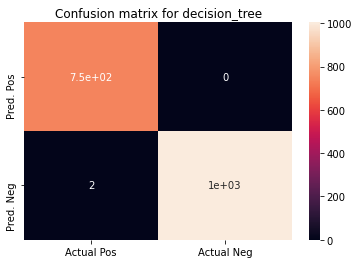

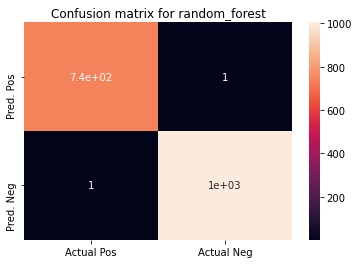

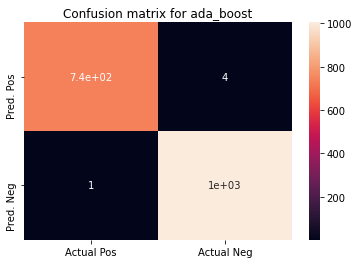

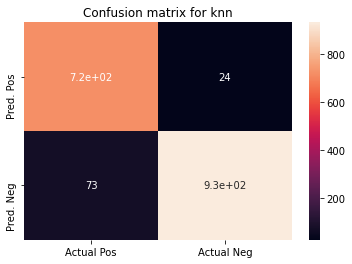

In [83]:
from sklearn.metrics import confusion_matrix
# Compute the four values tp, fp, fn, tn and plot them using plot_confusion_matrix

def plot_confusion_matrix(pred_data, actual_data, model_type):
    """
    Plots a confusion matrix using the values 
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    tn, fp, fn, tp = confusion_matrix(y_true = pred_data, 
                                  y_pred = actual_data.to_numpy()).ravel()
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg']) 
    plt.title('Confusion matrix for {}'.format(model_type))
    plt.show()
    

plot_confusion_matrix(tree['validate_pred'], valid_stage2['certified'], model_type = "decision_tree")
plot_confusion_matrix(rand['validate_pred'], valid_stage2['certified'], model_type = "random_forest")
plot_confusion_matrix(ada['validate_pred'], valid_stage2['certified'], model_type = "ada_boost")
plot_confusion_matrix(knn['validate_pred'], valid_stage2['certified'], model_type = "knn")

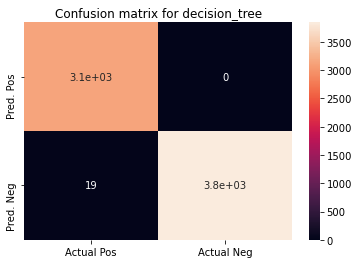

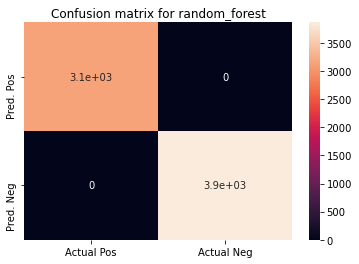

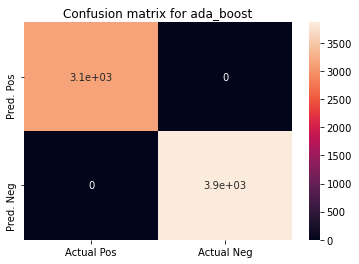

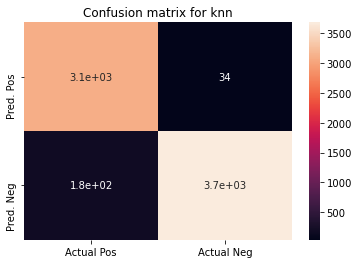

In [84]:
# confusion matrices for our training data
plot_confusion_matrix(tree['train_pred'], train_stage2['certified'], model_type = "decision_tree")
plot_confusion_matrix(rand['train_pred'], train_stage2['certified'], model_type = "random_forest")
plot_confusion_matrix(ada['train_pred'], train_stage2['certified'], model_type = "ada_boost")
plot_confusion_matrix(knn['train_pred'], train_stage2['certified'], model_type = "knn")

In [85]:
from sklearn.metrics import roc_curve

def plot_roc_curve_model(actual_data, pred_prob,model_type = "tree"):
    '''
      Parameters:
      ===================
      first argument = true values, second argument = predicted probabilities
      roc_curve returns 3 objects fpr, tpr, thresholds
      fpr: false positive rate
      tpr: true positive rate
    '''

    fpr, tpr, thresholds = roc_curve(actual_data.to_numpy(),
                                     pred_prob[:, 1])

    plt.plot(fpr, tpr)
    plt.title('ROC curve for {} classifier'.format(model_type))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()



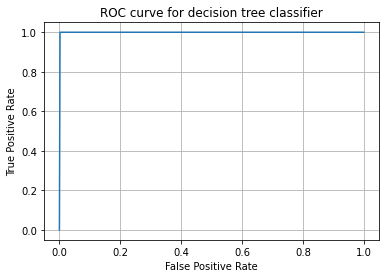

In [86]:
plot_roc_curve_model(actual_data=valid_stage2['certified'], pred_prob = tree['validate_pred_prob'], 
               model_type = "decision tree")

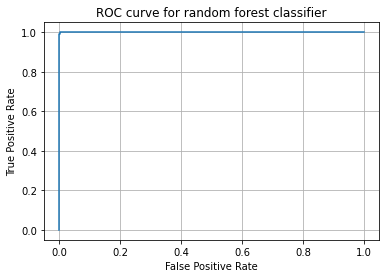

In [87]:
plot_roc_curve_model(actual_data=valid_stage2['certified'], pred_prob = rand['validate_pred_prob'], 
               model_type = "random forest")


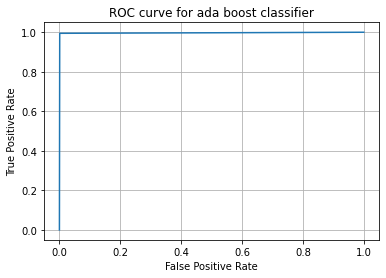

In [88]:
plot_roc_curve_model(actual_data=valid_stage2['certified'], pred_prob = ada['validate_pred_prob'], 
               model_type = "ada boost")

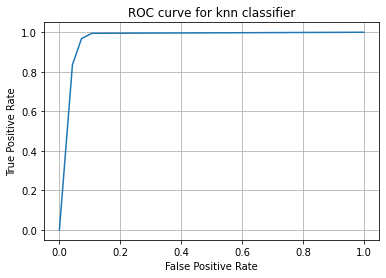

In [89]:
plot_roc_curve_model(actual_data=valid_stage2['certified'], pred_prob = knn['validate_pred_prob'], 
               model_type = "knn")

## Summary of Results
Here we can see that the performance of the Decision Tree and Random Tree models performed the best on the validation set and thus we concluded with using the Decision Tree Classifier yielded the best results. Using feature selection, it did help improve the random forest classifier to match the decision tree model out of the best performing models prior. 

To summarize, I improved my initial predictions by imputing the grade variable. I also improved my initial predictions by using feature selection. I tried encoding some variables/feature engineering (see feature engineering selection) but they didn't add a lot of explanatory value to our dataset. Here the ROC curves for the decision tree and random forest models reflect a perfect test almost as it's able to discriminate between the classifed and non-classified with 100 % sensitivity and 100 % specificity as opposed to the knn model which struggles a bit, helping assert that the random forest and decision tree models are very efficient and have a very high true positive rate compared to false positive rate. 

Given the ethnical implications of the following: "Their idea is to use the model to help predict which student groups (i.e. from specific countries or certain educational backgrounds) would make them the most money by getting the most participants to complete their paid certificate program. Are there any ethical considerations we should think about before acting on that plan?"

There are a lot of ethical considerations because what we are doing by predicting which student groups is assuming/generalizing an entire group of students. We have to consider if we are blocking access/resources for a given group of students simply because possibly the model we made happen to predict correctly majority of students there didn't get certified. We also have to consider any external factors that may not be taken into consideration (and we can't since every individual is unique/has a unique background) such as if the country the students are from are undergoing some war/conflict, students experiencing difficulties at home, etc. As well, every student's experience is unique based on their own educational background and cannot be used to determine if they will be certified or not. 

In [90]:
# the selected best model to run testing data on
pred = train_and_evaluate_model(model = DecisionTreeClassifier,
                                 model_type = "decision",
                                 model_params = best_params_decision, 
                                 X_train = train_stage2[best_features], y_train = train_stage2['certified'], 
                                 X_valid = valid_stage2[best_features], y_valid = valid_stage2['certified'],
                                 run_test = True,
                                 X_test = test_data_tran[best_features],
                                 y_test = pd.DataFrame({"hi":[12,33]}), return_pred = True)['test_pred']